# Cuk Converter State Space Model

In [23]:
# !pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca
import sympy as sym

from IPython.display import display, Math

import sys
sys.path.insert(0, '../')

from state_space_utils import *


circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    style="american",
    draw_nodes=True,
    label_nodes=True,
    cpt_size=2,
    node_spacing=4,
    size=0.1,
    scale=0.25,
    dpi=300,
)

The Cuk Converter:


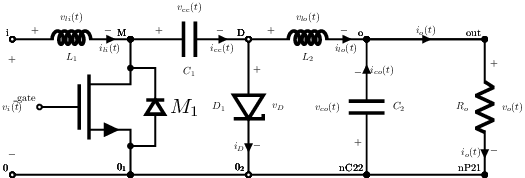

Operation step 1: Switch is ON


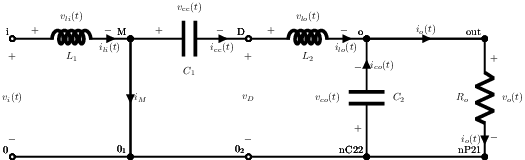

<IPython.core.display.Math object>

Operation step 2: Switch is OFF


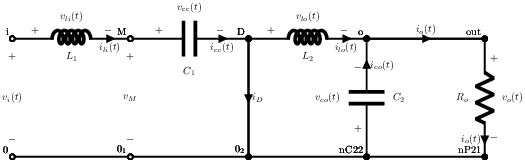

<IPython.core.display.Math object>

Averaged Large-Signal Model:


<IPython.core.display.Math object>

Averaged Small-Signal Model - First-order linearization:


<IPython.core.display.Math object>

In [24]:
class cuk:
    def netlist(state: bool = -1):
        return "\n".join(
            filter(
                None,
                [
                    cuk._input(),
                    cuk._commutation_cell(state),
                    cuk._output(),
                ],
            )
        )

    def _input():
        source = "\n".join(
            [
                "P1 i 0; down, v={v_{i}(t)}",
                "V1 i 0 {vi(t)}; down, i={i_{i}(t)}, v={v_{i}(t)}, invisible",
            ]
        )
        inductor = "L1 i M; right, i={i_{li}(t)}, v={v_{li}(t)}"
        ground = "W  0    0_1; right"
        return "\n".join(filter(None, [source, inductor, ground]))

    def _commutation_cell(state: bool = -1):
        capacitor = "C1 M D; right, i={i_{cc}(t)}, v={v_{cc}(t)}"
        if state == -1:
            switches = "\n".join(
                [
                    "M1 M _gate 0_1 nmos; nosim, right=0.7, bodydiode, arrowmos, i={i_{M}}, v={v_{M}}"
                    + ("" if state == -1 else ", invisible"),
                    "D1 D 0_2 schottky; nosim, down, i={i_{D}}, v={v_{D}}"
                    + ("" if state == -1 else ", invisible"),
                ]
            )
        else:
            switches = ""

        ground = "W  0_1 0_2; right"
        if state:
            switches_for_simulation = "\n".join(
                [
                    "W  M 0_1; down, i={i_{M}}"
                    + (", invisible" if state == -1 else ""),
                    "P3 D 0_2; down, v={v_{D}}"
                    + (", invisible" if state == -1 else ""),
                ]
            )
        else:
            switches_for_simulation = "\n".join(
                [
                    "P3 M 0_1; down, v={v_{M}}"
                    + (", invisible" if state == -1 else ""),
                    "W  D 0_2; down, i={i_{D}}"
                    + (", invisible" if state == -1 else ""),
                ]
            )

        return "\n".join(
            filter(None, [capacitor, switches, switches_for_simulation, ground])
        )

    def _output():
        load = "\n".join(
            [
                # "P2 out nP21; down, v={v_{o}(t)}",
                # "I1 out nP21 {io(t)}; down",#, invisible",
                # "Ro out nP21; down, i={i_{o}(t)}, invisible",
                # "I1 nP22 o2 {io(t)}; up",#, invisible",
                # "W  o2 out; left",
                # "W  nP21 nP22; right",
                "Ro out nP21; down, i={i_{o}(t)}, v={v_{o}(t)}",
                # "I1 out c {io(t)}; down",
                # "Ro c nP21; down, i={i_{o}(t)}",
                "W  o out; right, i={i_{o}(t)}",
            ]
        )
        inductor = "L2 D o; right, i={i_{lo}(t)}, v={v_{lo}(t)}"
        capacitor = "C2 nC22 o; up, i={i_{co}(t)}, v={v_{co}(t)}"
        ground = "\n".join(
            [
                "W  nC22 nP21; right",
                "W  0_2  nC22; right",
            ]
        )

        return "\n".join(filter(None, [load, inductor, capacitor, ground]))

    def describe():
        print("The Cuk Converter:")
        cct = lca.Circuit(netlist=cuk.netlist()).subs({}) # <- FIXME: workaround for lcapy's issue #74
        cct.draw(**circuit_draw_params)

        print("Operation step 1: Switch is ON")
        cct_on = lca.Circuit(netlist=cuk.netlist(True)).subs({}) # <- FIXME: workaround for lcapy's issue #74
        cct_on.draw(**circuit_draw_params)

        ss_on = cct_on.ss
        # ss_on = select_outputs(ss_on, outputs=[2, 4, 8])
        display_lcapy_ss(ss_on)

        print("Operation step 2: Switch is OFF")
        cct_off = lca.Circuit(netlist=cuk.netlist(False)).subs({}) # <- FIXME: workaround for lcapy's issue #74
        cct_off.draw(**circuit_draw_params)

        ss_off = cct_off.ss
        # select_outputs(ss_off, outputs=[2, 4, 8])
        display_lcapy_ss(ss_off)

        dt = sym.Function('d')(lca.t)

        print("Averaged Large-Signal Model:")
        ss_lsm = get_averaged_large_signal_model(ss_on, ss_off, dt=dt)
        display_lcapy_ss(ss_lsm)

        print("Averaged Small-Signal Model - First-order linearization:")
        ss_ssm = get_averaged_small_signal_model(ss_on, ss_off, dt=dt)
        display_lcapy_ss(ss_ssm)

        return cct, cct_on, cct_off, ss_on, ss_off, ss_lsm, ss_ssm


cct, cct_on, cct_off, ss_on, ss_off, ss_lsm, ss_ssm = cuk.describe()

---

In [25]:
# ss_ssm.B[-2] = ss_ssm.A[-1].expand().simplify()
# display(ss_ssm.B[-2])

In [26]:
import pandas as pd

x_names = [str(expr.name).replace('\hat{', '').replace('}', '') for expr in ss_lsm.x]
y_names = [str(expr.name).replace('\hat{', '').replace('}', '') for expr in ss_lsm.y]
u_names = [str(expr.name).replace('\hat{', '').replace('}', '') for expr in ss_lsm.u]

df = pd.read_csv("./MAM17_PSIM_simulation_ideal.csv")

print(x_names)
print(y_names)
print(u_names)
print(df.columns)
df.rename(columns={
    'Time': 't',
    'I(Li)': y_names[4],
    'I(Lo)': y_names[7],
    'I(C)': y_names[5],
    'I(Co)': y_names[8],
    'Is': '_Is', # ignored
    'ID': '_ID', # ignored
    'I(Ro)': y_names[6],
    'Iin': y_names[3],
    # 'Io': '_Io', #u_names[1],
    'VD': y_names[0],
    'VC': x_names[2],
    'Pmax': '_Pmax', # ignored
    'Vs': '_Vs', # ignored
    'Vin': y_names[1],
    # 'var_Duty_Cycle': u_names[1],
    'VCo': x_names[3],
    'Vo': y_names[2],
}, inplace=True)
df[u_names[0]] = df[y_names[1]]
# df[y_names[6]] = df[y_names[4]]
df.set_index('t', drop=True, inplace=True)
df = df[[col for col in df.columns if not col.startswith('_')]] # remove ignored columns

# Remove non-used variables
x_names_filt = [name for name in x_names if name in df.columns]
y_names_filt = [name for name in y_names if name in df.columns]
u_names_filt = [name for name in u_names if name in df.columns]

import matplotlib.pyplot as plt
def plot_dataset(df):
    for col in df.columns:
        plt.figure(figsize=(20,5))
        plt.title(col)
        plt.plot(df.index, df[col], label='PSIM Simulation data')
        plt.legend(loc='lower right')
        plt.show()

# display(df)
# plot_dataset(df)

['i_L1', 'i_L2', 'v_C1', 'v_C2']
['v_D', 'v_i', 'v_o', 'i_V1', 'i_L1', 'i_C1', 'i_Ro', 'i_L2', 'i_C2']
['vi']
Index(['Time', 'I(C)', 'I(Li)', 'I(Co)', 'I(Lo)', 'Is', 'ID', 'I(Ro)', 'Iin',
       'Io', 'VD', 'VC', 'Pmax', 'Vs', 'Vin', 'var_Duty_Cycle', 'VCo', 'Vo'],
      dtype='object')


## Get the simulation data
In order to test the model, let's play with a simulation data from a non-ideal Cuk simulation done in PSIM.

In [27]:
"""
TODO: COMO SIMULAR?
 -[x] Substituir valores das constantes
 -[x] Transformar para python-control
 -[x] Criar sinais para as entradas (importar de uma simulação do PSIM de 2017)
 -[x] Simular
 -[x] Plotar
"""

' \nTODO: COMO SIMULAR?\n -[x] Substituir valores das constantes\n -[x] Transformar para python-control\n -[x] Criar sinais para as entradas (importar de uma simulação do PSIM de 2017)\n -[x] Simular\n -[x] Plotar\n'

In [28]:
df['i_L1'] = -df['i_L1']
df['i_L2'] = -df['i_L2']
# df['i_V1'] = -df['i_V1']
df['i_Ro'] = -df['i_Ro']
df['i_C1'] = -df['i_C1']
df['i_C2'] = -df['i_C2']
df['v_o'] = -df['v_o']
df.mean()

i_C1               0.006192
i_L1              -8.801195
i_C2              -0.002972
i_L2               5.853110
i_Ro              -5.850138
i_V1               8.801195
Io                 5.850138
v_D              -42.783328
v_C1              71.363726
v_i               28.563071
var_Duty_Cycle     0.600000
v_C2              42.803132
v_o              -42.803123
vi                28.563071
dtype: float64

In [29]:
""" Average values from the simulation:
I(Li)            	8.7939896e+000
I(Lo)            	5.8481843e+000
var_Duty_Cycle   	6.0000000e-001
VC               	7.1418717e+001
VCo              	4.2767107e+001
Vo               	4.2767101e+001
I(Ro)            	5.8452151e+000
"""
values = {
    'C1': 4.933e-6,
    'C2': 3.4169e-6,
    'L1': 109.0963e-6,
    'L2': 146.0498e-6,
    'Ro': 7.3166,
    # r'\bar{d}': df[u_names[1]].mean(),
    ss_lsm.A[2].args[2].args[1].args[1]: 0.6,
    r'\bar{i}_L1': df[x_names[0]].mean(),
    r'\bar{i}_L2': df[x_names[1]].mean(),
    r'\bar{v}_C1': df[x_names[2]].mean(),
    r'\bar{v}_C2': df[x_names[3]].mean(),
}
display(values)

ss_vals = ss_lsm.subs(values)
display_lcapy_ss(ss_vals)
print('Is controlable:', ss_vals.is_controllable)
print('Is observable:', ss_vals.is_observable)

{'C1': 4.933e-06,
 'C2': 3.4169e-06,
 'L1': 0.0001090963,
 'L2': 0.0001460498,
 'Ro': 7.3166,
 d(): 0.6,
 '\\bar{i}_L1': -8.801195077833535,
 '\\bar{i}_L2': 5.853110200151739,
 '\\bar{v}_C1': 71.36372576124707,
 '\\bar{v}_C2': 42.80313185258721}

<IPython.core.display.Math object>

Is controlable: True
Is observable: True


## State Space Simulation

In [30]:
import control
# controlconfig.defaults['control.default_dt'] = 1e-5
# control.config.defaults['statesp.latex_repr_type'] = 'partitioned'
# control.config.defaults['statesp.latex_num_format'] =

ss = lcapy_statespace_to_pythoncontrol(ss_vals)
# ss

In [31]:
# Prepare the inputs signals
t = df.index.to_numpy().T
U = df[[*u_names]].to_numpy().T
# display(df[[*u_names]])

# Simulate applying the inputs signals
t, yout, xout = control.forced_response(ss, t, U, return_x=True, squeeze=True)

# Gather the outputs and states signals
df_xout = pd.DataFrame(xout.T, index=t.T, columns=[*x_names])
df_yout = pd.DataFrame(yout.T, index=t.T, columns=[*y_names])
df_xout.index.rename('t', inplace=True)
df_yout.index.rename('t', inplace=True)
# display(df_xout)
# display(df_yout)

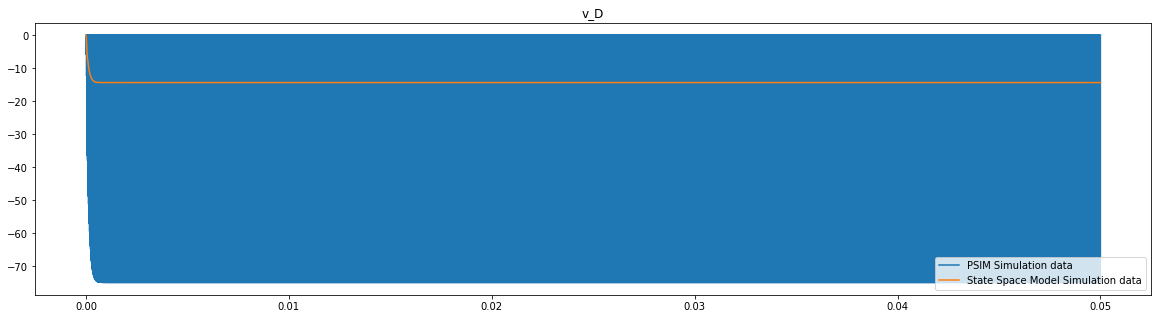

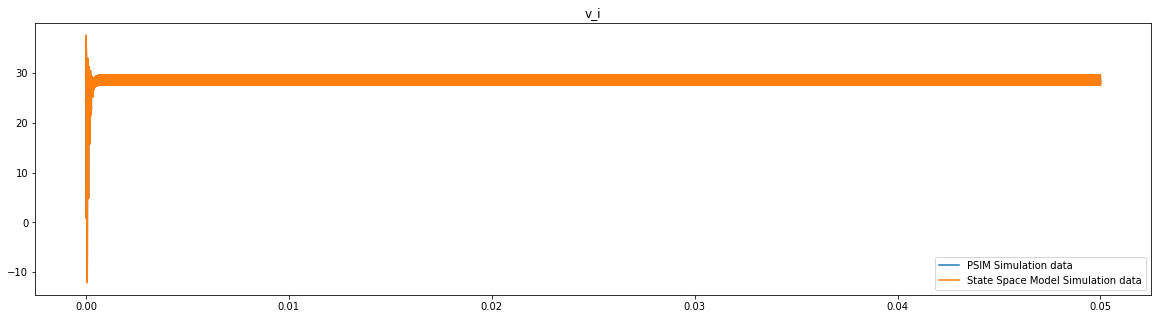

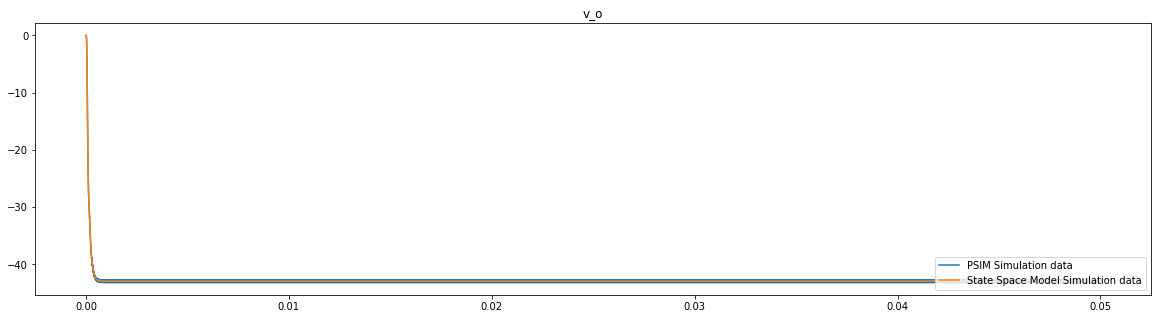

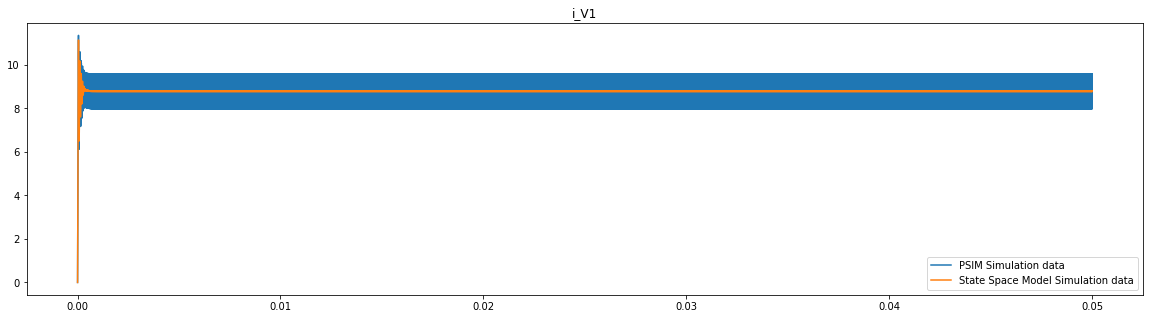

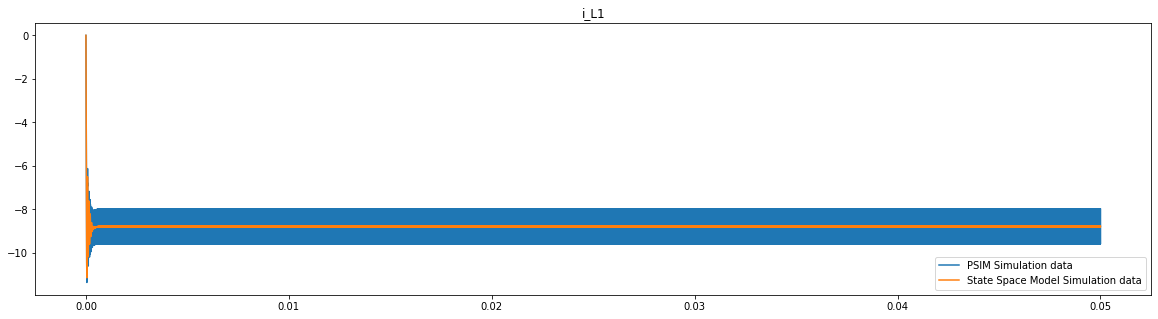

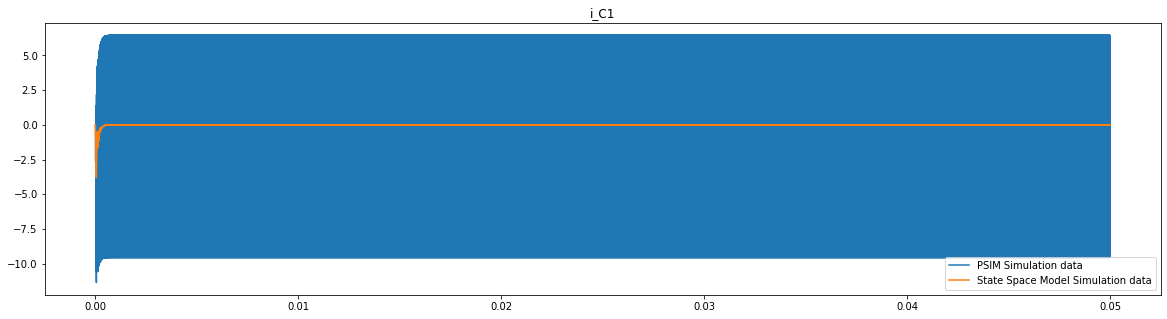

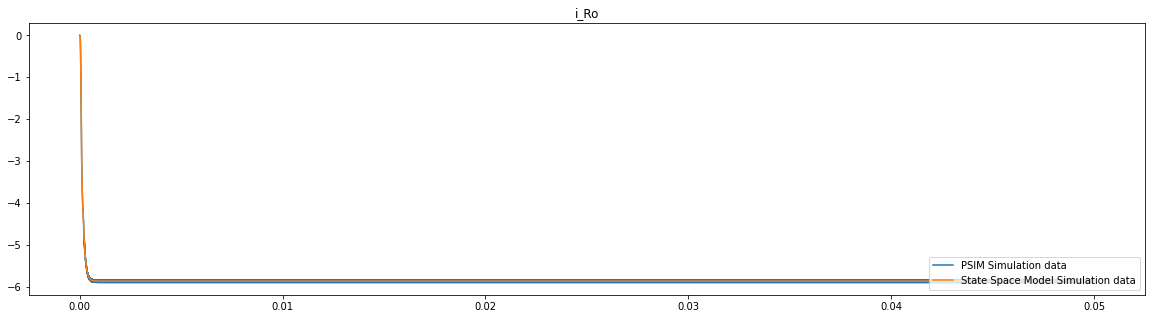

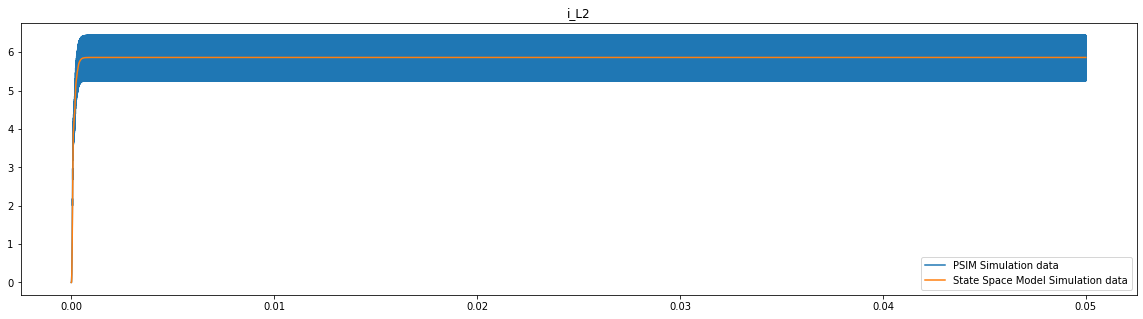

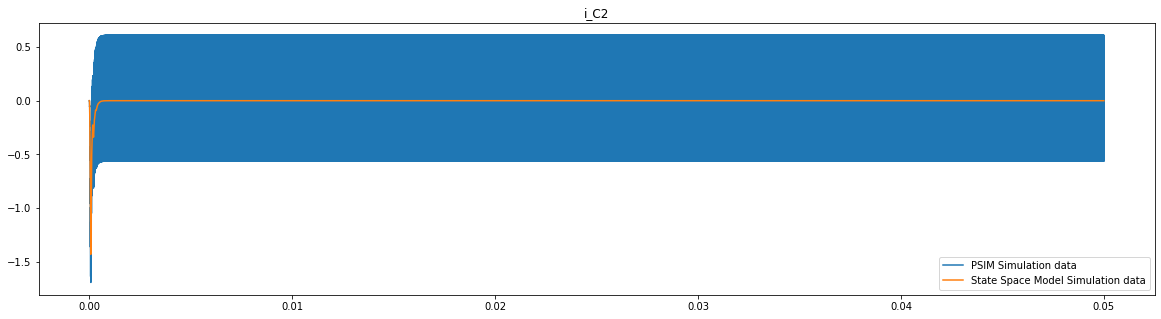

In [32]:
import matplotlib.pyplot as plt
def plot_simulation(df_in, df_out):
    for col in y_names:
        plt.figure(figsize=(20,5))
        plt.title(col)
        plt.plot(df.index, df_in[col], label='PSIM Simulation data')
        plt.plot(df_out.index, df_out[col], label='State Space Model Simulation data')
        plt.legend(loc='lower right')
        plt.show()

plot_simulation(df, df_yout)